1. Import packages that we will use 

In [ ]:
import pandas as pd
import pandas_bokeh
import matplotlib.pyplot as plt
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
pandas_bokeh.output_notebook()
import plotly.graph_objects as go
import seaborn as sns
nomi = pgeocode.Nominatim('us')
from IPython.display import Image
from IPython.core.display import HTML 

In [643]:
import scipy
from scipy import stats
import numpy as np
import statsmodels.api as sm 
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

suppres the warning printing 

In [591]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2. get the current working directory and read the files 

In [7]:
import os
os.getcwd()
#os.chdir('/Users/yuangu/Downloads/publicstorage')

'/Users/yuangu/Downloads/publicstorage'

In [35]:
locations = pd.read_csv('property locations.csv')

# Look at the property location file, generate some descriptive information

In [51]:
#rename 'Owner/Operator, Franchise' to 'company'
locations.rename(columns = {'Owner/Operator, Franchise':'company'}, inplace = True)
print(locations.columns)
print(locations.shape) ## total 4431 rows and 10 columns

Index(['Market', 'company', 'ADDRESS', 'CTY', 'ST', 'Zip', 'Area', 'Year',
       'count', 'publicstorage'],
      dtype='object')
(4431, 10)


<AxesSubplot:>

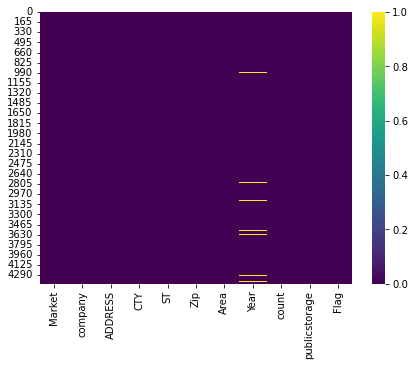

In [587]:
# Exploring missing data and checking if any has NaN values
plt.figure(figsize=(7, 5))
sns.heatmap(locations.isnull(), cmap='viridis') # year has some 76 missing values

In [47]:
locations['company'].value_counts() ## Public Storage has the most propereis in the US 

Public Storage                     2442
Extra Space Storage                1099
CubeSmart Self Storage              599
StorageMart                         111
EZ Storage                           90
Public Storage Phase II              51
Storage Mart                         11
Extra Space Storage Phase II          8
EZ Storage Phase II                   4
Ez Storage                            4
Cubesmart Self Storage                3
Public Storage Phase ll               3
StorageMart Phase II                  2
CubeSmart Self Storage Phase II       1
Extra Space Storage Phase ll          1
PS Business Parks                     1
Public Storage Phase III              1
Name: company, dtype: int64

In [48]:
## group public storage, public storage phase II, Public Storage Phase ll  and Public Storage Phase III  
locations['publicstorage'] = locations.company.str.contains('Public Storage', na=False)

In [662]:
locations.publicstorage.value_counts() ## now we have public storage vs other company counts ： 2497 VS 1934

True     2497
False    1934
Name: publicstorage, dtype: int64

In [52]:
locations['count'] = locations.groupby('publicstorage')['publicstorage'].transform('count')

In [522]:
locations_map = locations[["company","publicstorage", "CTY", "Zip", "count", "ST","Year"]] 
## select columns we will use

In [592]:
## get the latitutd and longitude from the zipcode 
locations_map['zipcode'] = locations_map['Zip'].astype(str).str.replace('.', '')
#nomi.query_postal_code(locations_map['zipcode'].tolist())
locations_map['Latitude'] = (nomi.query_postal_code(locations_map['zipcode'].tolist()).latitude)
locations_map['Longitude'] = (nomi.query_postal_code(locations_map['zipcode'].tolist()).longitude)

In [663]:
locations_map.head() ## look at the data 

,company,publicstorage,CTY,Zip,count,ST,Year,zipcode,Latitude,Longitude
0,Extra Space Storage,False,Santa Fe,87505,1934,NM,2000.0,87505,35.6219,-105.8688
1,Extra Space Storage,False,Rio Rancho,87124,1934,NM,2000.0,87124,35.2493,-106.6818
2,Extra Space Storage,False,Albuquerque,87114,1934,NM,1998.0,87114,35.1868,-106.6652
3,Extra Space Storage,False,Albuquerque,87111,1934,NM,1997.0,87111,35.1347,-106.5222
4,Extra Space Storage,False,Albuquerque,87114,1934,NM,1998.0,87114,35.1868,-106.6652


look at the self storage distribution on the US map 
<br>1, most storage are distributed in the coast busy area;
<br>2, public storage is covering most area as other companies except west TX and NM;
<br>3, more storages are distributed in middle south than mid west;

In [659]:
fig = go.Figure(data=go.Scattergeo(
        lon = locations_map['Longitude'],
        lat = locations_map['Latitude'],
        text = locations_map['ST'],
        mode = 'markers',
        marker_color = locations_map['count'],
        ))

fig.update_layout(
        title = 'self storage distributions:  yellow dot (public storage) vs blue dot (others)',
        geo_scope='usa',
    )
fig.show()

The bar plot of count by different states shows that:
<br>1, top three states are CA, TX, FL
<br>2, the top states have larger population compare to other states

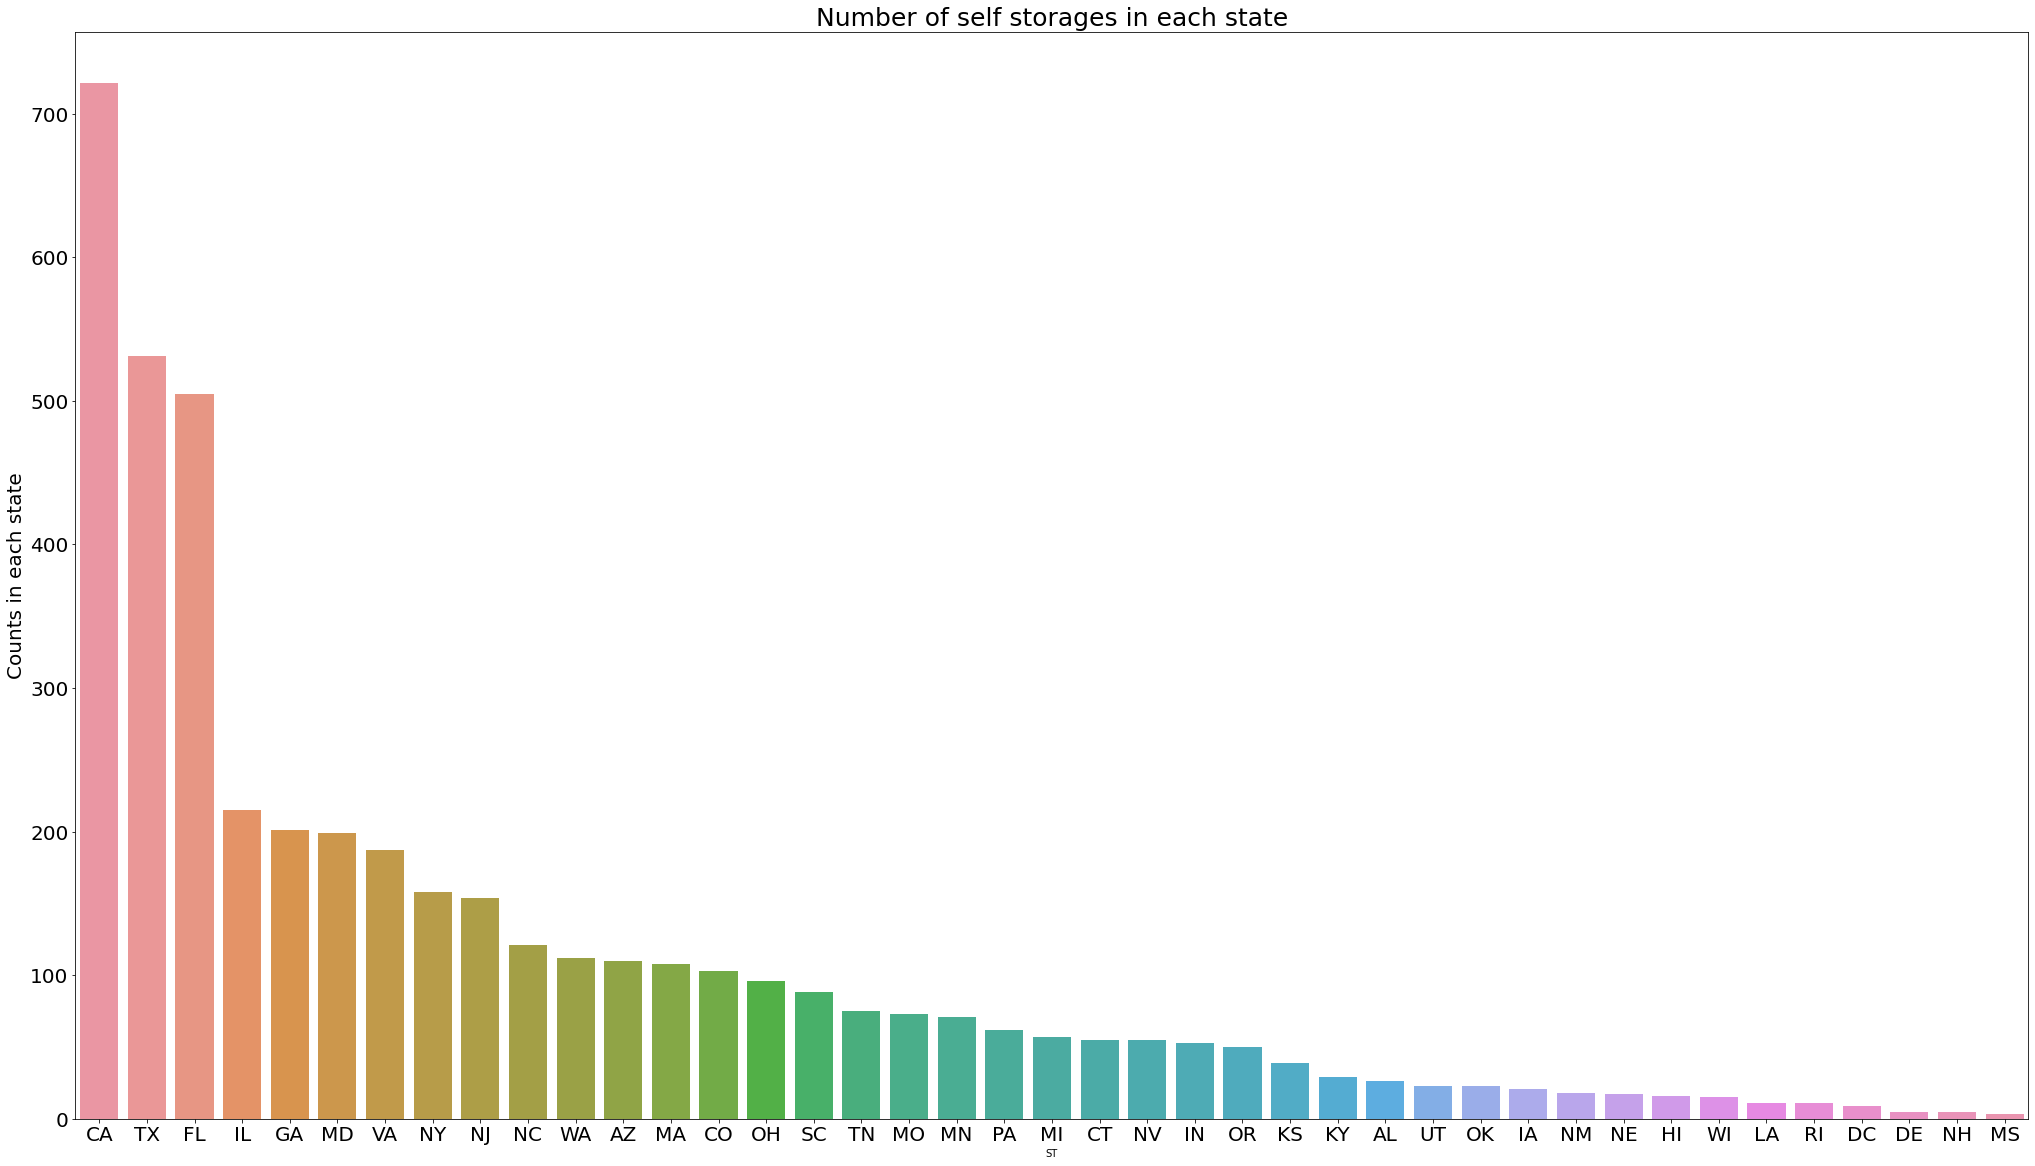

In [527]:
plt.figure(figsize = (35,20))
plt.title('Number of self storages in each state',fontsize=25)
s = sns.countplot(data=locations, x='ST', order=locations.ST.value_counts().index)
s.set_ylabel("Counts in each state", fontsize = 20)
s.tick_params(labelsize=20)
plt.show()

Check the number of storage by year
<br>1, storage counts are increasing after 1980 
<br>2, 76 observations are missing 
<br>3, numbers is decreasing after 1990 

In [531]:
locations.Year.value_counts()

2000.0    187
1988.0    184
1987.0    180
1985.0    174
1986.0    172
         ... 
1930.0      1
1946.0      1
1940.0      1
2021.0      1
1922.0      1
Name: Year, Length: 87, dtype: int64

In [594]:
m1 = (locations['Year']<=1980)
m2 = (locations['Year']<=1990) & (locations['Year']> 1980)
m3 = (locations['Year']<=2000) & (locations['Year']> 1990)
m4 = (locations['Year']<=2010) & (locations['Year']> 2000)
m5 = (locations['Year']> 2010)
m6 = (locations['Year'].isnull())

4431


In [595]:
locations.loc[m1, 'Flag'] = 'period1:<1980'
locations.loc[m2, 'Flag'] = 'period2:1980-1990'
locations.loc[m3, 'Flag'] = 'period3:1990-2000'
locations.loc[m4, 'Flag'] = 'period4:2000-2010'
locations.loc[m5, 'Flag'] = 'period5:>2010'
locations.loc[m6, 'Flag'] = 'Unknownyear'
locations.Flag.value_counts()

period2:1980-1990    1324
period3:1990-2000    1090
period4:2000-2010     972
period1:<1980         622
period5:>2010         347
Unknownyear            76
Name: Flag, dtype: int64

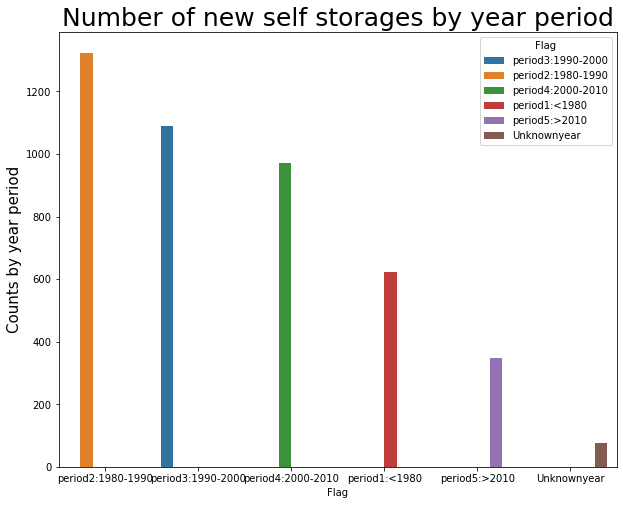

In [664]:
plt.figure(figsize = (10,8))
plt.title('Number of new self storages by year period',fontsize=25)
s = sns.countplot(data=locations, x='Flag', order=locations.Flag.value_counts().index, hue='Flag',)
s.set_ylabel("Counts by year period", fontsize = 15)
s.tick_params(labelsize=10)
plt.show()

# Import public data 
## the following are the links for the downloaded files:
<br>1. rental vacancy rate: the higher rent vacancy rate, the less rental, the less storage renting 
https://fred.stlouisfed.org/release/tables?rid=144&eid=258450&od=1984-01-01#
<br>2. demographic: larger population living in less average space more likely to use public storage
 download from https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates/2020-evaluation-estimates/2010s-state-detail.html
<br>3. employment rate: more rich, more money to rent  https://www.bls.gov/sae/tables/state-news-release/home.htm
<br>4. SPI data: https://www.bea.gov/sites/default/files/2022-06/spi0622.pdf
<br>5. population change:  https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/
<br>6. storage unit cost by states: https://www.lifestorage.com/blog/storage/storage-unit-costs/
<br>7. Due to my limited time, I could not handle many datasets. The other data I was also considering: 
<br> -- 7.1. education level by states; - higher education, higher salary, eagar to use rent storage. 
<br> --7.2. race, sex and culture by states; - such as women have more cloth to store. 
<br> --7.3. university area in the states; - students are more likely to rent storage during summer.
<br> -- 7.4. traffic convinient by states; - easy or not for people to commute to the storage
<br> -- 7.5. age group trend by states; - look at elder people or younger people group rent trend, millennial lifestyle change;
<br> -- 7.6. job/market trend by states; - more active job and WFH job, more people are moving 
and considering rent
<br> -- 7.7. construction, spending cost, tax, insurance cost, etc;
<br> -- 7.8. rural/city expand trend, etc;
<br> 8. other features need to be consider: 
<br> -- 8.1. weather and seasonal factor
<br> -- 8.2. other competitors and potential market such as small business, other rental market such as Zillow, Redfin; 
<br> -- 8.3. covid19 recovery;
<br> -- 8.4. recession recovery;
<br> -- 8.5. government new construction , rent policy;
<br> 9. potential investment etc. 
<br> 10. technical improvement such as, non contact rent, environment control etc.  

In [596]:
rent_vacancy2022= pd.read_excel('tab1_state05_2022_rvr.xlsx', skiprows=8, nrows=51, header=None)
rent_vacancy2021= pd.read_excel('tab1_state05_2022_rvr.xlsx', skiprows=69, nrows=51, header=None)
rent_vacancy2021= rent_vacancy2021.iloc[:,[0,1,3,5,7]]
rent_vacancy2022= rent_vacancy2022.iloc[:,[0,1,3]]
rent_vacancy2021.columns =['ST', 'Qua1_2021', 'Qua2_2021', 'Qua3_2021','Qua4_2021']
rent_vacancy2022.columns =['ST', 'Qua1_2022', 'Qua2_2022']
rent_vacancy= rent_vacancy2021.merge(rent_vacancy2022, how='inner', on='ST')
rent_vacancy.sort_values(by=['Qua2_2022']) ## sort by the last quater rental vacancy rate from small to large

,ST,Qua1_2021,Qua2_2021,Qua3_2021,Qua4_2021,Qua1_2022,Qua2_2022
6,Connecticut......................................,6.1,5.4,4.1,4.7,4.7,2.1
45,Vermont..........................................,1.8,1.8,3.5,2.7,2.5,2.4
7,Delaware.........................................,3.0,3.8,3.0,5.5,3.3,2.6
21,Massachusetts................................,6.6,4.5,2.1,3.4,2.8,2.7
49,Wisconsin........................................,4.5,3.5,5.1,5.4,4.9,3.2
30,New Jersey.......................................,5.4,3.5,3.1,2.5,4.0,3.2
37,Oregon...........................................,4.1,4.7,5.8,3.3,6.2,3.3
26,Montana..........................................,4.2,4.3,3.8,4.1,3.4,3.6
17,Kentucky.........................................,6.2,6.8,5.5,6.0,5.6,3.8
12,Idaho............................................,5.2,4.0,3.4,4.8,3.3,3.8


In [597]:
rent_vacancy = rent_vacancy.set_index('ST')

## the rent vacancy trend is decreasing the two years, indicating that more people are rentals

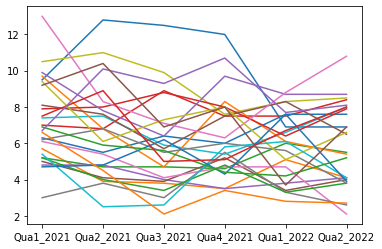

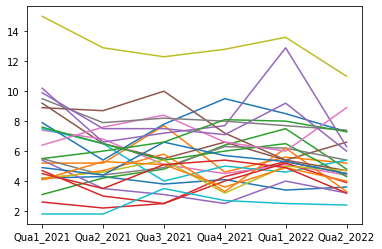

In [598]:
for index, row in rent_vacancy[:26].iterrows():
    plt.plot(row, label=index)
plt.show()

for index, row in rent_vacancy[26:].iterrows():
    plt.plot(row, label=index)
plt.show() 

In [197]:
# ***Import the Census rent trend plot***
Image(url= "https://ipropertymanagement.com/wp-content/uploads/8954/12-month-rental-vacancy-rate-change.webp")

# more people are moving to the coast area, east and west,  while midwest is lossing people 

In [198]:
Image(url= "https://www.census.gov/content/dam/Census/library/stories/2022/03/what-has-driven-population-change-in-united-states-counties-map-2.jpg")

In [132]:
## demographic
## download from https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates/2020-evaluation-estimates/2010s-state-detail.html

In [252]:
demographic = pd.read_excel("sc-est2020-18^Mpop-res.xlsx", skiprows=9, nrows=51, header=None)
demographic.columns =['ST', 'Total_pop', 'Totalpop_above18', 'Totalpop_above18per']
demographic['ST']=demographic['ST'].astype('str').str.replace(r".", r"", regex=False)

In [253]:
demographic.head()

,ST,Total_pop,Totalpop_above18,Totalpop_above18per
0,Alabama,4921532,3834249,77.9
1,Alaska,731158,552427,75.6
2,Arizona,7421401,5774978,77.8
3,Arkansas,3030522,2330808,76.9
4,California,39368078,30576844,77.7


In [665]:
# the state column values contains special characters that need to remove, otherwise cannot merge with other dataset
demographic['ST'].astype('str').str.replace(r".", r"", regex=False) 

0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District of Columbia
9                  Florida
10                 Georgia
11                  Hawaii
12                   Idaho
13                Illinois
14                 Indiana
15                    Iowa
16                  Kansas
17                Kentucky
18               Louisiana
19                   Maine
20                Maryland
21           Massachusetts
22                Michigan
23               Minnesota
24             Mississippi
25                Missouri
26                 Montana
27                Nebraska
28                  Nevada
29           New Hampshire
30              New Jersey
31              New Mexico
32                New York
33          North Carolina
34            North Dakota
35                    Ohio
36                Oklahoma
3

In [264]:
rent_vacancy.reset_index(inplace=True)
rent_vacancy['ST']=rent_vacancy['ST'].astype('str').str.replace(r".", r"", regex=False)

In [266]:
rent_demo=pd.merge(rent_vacancy, demographic, on='ST', how='inner') ## inner join datasets by state variable 

In [ ]:
## employment date table3x.xlsx 
## download from https://www.bls.gov/sae/tables/state-news-release/home.htm

In [280]:
employment = pd.read_excel("table3x.xlsx", skiprows=6, nrows=64, header=None)
employment=employment.dropna(axis=0)
employment = employment.iloc[:,0:5]
employment.columns =['ST', 'Employ_June2021', 'Employ_Apr2022', 'Employ_May2022', 'Employ_June2022']

In [281]:
employment.head()

,ST,Employ_June2021,Employ_Apr2022,Employ_May2022,Employ_June2022
0,Alabama,2039.7,2067.5,2079.6,2079.1
1,Alaska,304.8,317.0,313.2,310.8
2,Arizona,2958.6,3041.7,3048.7,3063.7
3,Arkansas,1277.0,1309.8,1305.4,1309.5
4,California,16665.3,17455.2,17496.0,17515.9


In [282]:
rent_demo_employ=pd.merge(rent_demo, employment, on='ST', how='inner')

## SPI: state population income

In [326]:
spi = pd.read_excel("spi0622.xlsx", skiprows=6, nrows=58, header=None)
spi.columns =['ST', 'SPI_Q42020', 'SPI_Q12021', 'SPI_Q22021', 'SPI_Q32021','SPI_Q42021',
              'SPI_Q12022','SPI_Q12021_chg', 'SPI_Q22021_chg', 'SPI_Q32021_chg','SPI_Q42021_chg',
              'SPI_Q12022_chg','SPI_rank']
spi = spi[['ST', 'SPI_Q42020', 'SPI_Q12021', 'SPI_Q22021', 'SPI_Q32021','SPI_Q42021', 'SPI_Q12022_chg','SPI_rank']]
spi.ST=spi.ST.str.replace(' ', '')

In [327]:
spi.head()

,ST,SPI_Q42020,SPI_Q12021,SPI_Q22021,SPI_Q32021,SPI_Q42021,SPI_Q12022_chg,SPI_rank
0,Connecticut,279843,301476,291074,293272,295595,5.4,20
1,Maine,73069,82305,76739,77084,78138,5.0,27
2,Massachusetts,541732,587565,569281,573804,570101,7.1,8
3,NewHampshire,92455,100605,98908,99859,101819,7.7,5
4,RhodeIsland,63221,70428,67105,66947,66838,5.1,26


In [599]:
spi=spi.sort_values(by=['ST'])
rent_demo_employ_spi=pd.merge(rent_demo_employ, spi, on='ST', how='inner')
#[len(set(a).intersection(b)) for a, b in zip(rent_demo_employ_spi.ST, spi.ST)]

In [600]:
rent_demo_employ.head()

,index,ST,Qua1_2021,Qua2_2021,Qua3_2021,Qua4_2021,Qua1_2022,Qua2_2022,Total_pop,Totalpop_above18,Totalpop_above18per,Employ_June2021,Employ_Apr2022,Employ_May2022,Employ_June2022
0,0,Alabama,9.5,12.8,12.5,12.0,6.9,6.9,4921532,3834249,77.9,2039.7,2067.5,2079.6,2079.1
1,1,Alaska,5.7,3.9,3.8,3.5,5.1,4.1,731158,552427,75.6,304.8,317.0,313.2,310.8
2,2,Arizona,5.2,4.7,4.7,4.6,6.0,5.5,7421401,5774978,77.8,2958.6,3041.7,3048.7,3063.7
3,3,Arkansas,7.0,6.8,8.9,7.5,7.5,8.4,3030522,2330808,76.9,1277.0,1309.8,1305.4,1309.5
4,4,California,4.8,4.8,4.0,3.5,3.8,4.1,39368078,30576844,77.7,16665.3,17455.2,17496.0,17515.9


In [336]:
populationchange = pd.read_csv("NST-EST2021-popchg2020_2021.csv")
## https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/state/totals/

In [338]:
populationchange = populationchange[["NAME", "NPOPCHG_2021", "PPOPCHG_2021", "NRANK_PPCHG2021"]]

In [342]:
populationchange.columns = ["ST", "NPOPCHG_2021", "PPOPCHG_2021", "NRANK_PPCHG2021"]

In [345]:
rent_demo_employ_spi_popchange=pd.merge(populationchange, rent_demo_employ_spi, on='ST', how='inner')

In [348]:
rent_demo_employ_spi_popchange

,ST,NPOPCHG_2021,PPOPCHG_2021,NRANK_PPCHG2021,index,Qua1_2021,Qua2_2021,Qua3_2021,Qua4_2021,Qua1_2022,...,Employ_Apr2022,Employ_May2022,Employ_June2022,SPI_Q42020,SPI_Q12021,SPI_Q22021,SPI_Q32021,SPI_Q42021,SPI_Q12022_chg,SPI_rank
0,Alabama,15074,0.299992,20,0,9.5,12.8,12.5,12.0,6.9,...,2067.5,2079.6,2079.1,225742,260454,237897,239116,243278,3.5,41
1,Alaska,232,0.031675,32,1,5.7,3.9,3.8,3.5,5.1,...,317.0,313.2,310.8,45944,50864,48239,48453,49434,2.0,47
2,Arizona,98330,1.369883,4,2,5.2,4.7,4.7,4.6,6.0,...,3041.7,3048.7,3063.7,366328,412545,384968,389415,397407,2.4,46
3,Arkansas,13659,0.453451,19,3,7.0,6.8,8.9,7.5,7.5,...,1309.8,1305.4,1309.5,141513,163063,150847,151698,152715,5.5,18
4,California,-261902,-0.663047,47,4,4.8,4.8,4.0,3.5,3.8,...,17455.2,17496.0,17515.9,2787817,3068449,2944410,2987495,2980734,5.4,21
5,Colorado,27761,0.479936,17,5,5.0,4.1,3.9,5.2,3.4,...,2850.0,2852.9,2857.4,370645,409394,393347,398636,407544,5.3,22
6,Connecticut,5337,0.148239,25,6,6.1,5.4,4.1,4.7,4.7,...,1646.9,1649.3,1651.0,279843,301476,291074,293272,295595,5.4,20
7,Florida,211196,0.979122,8,9,7.4,7.5,5.9,5.4,6.6,...,9287.9,9313.9,9344.5,1203300,1366282,1294868,1306526,1335590,4.4,32
8,Georgia,73766,0.687744,15,10,6.3,5.5,6.4,6.0,7.6,...,4764.3,4783.7,4801.8,547594,625512,585011,584932,595558,3.8,40
9,Idaho,53151,2.876491,1,12,5.2,4.0,3.4,4.8,3.3,...,815.2,814.3,818.5,90236,102485,94752,95680,98888,7.7,4


In [ ]:
#https://www.lifestorage.com/blog/storage/storage-unit-costs/

In [601]:
storageprice = pd.read_csv("data (1).csv")
storageprice_climate = pd.read_csv("data (2).csv")

In [602]:
abbr = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts",
          "MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina",
          "SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont",
          "VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming", "DC": "District of Columbia"}
storageprice['ST'] = [states[i] for i in storageprice['State']] ## map the abbrevation of states to full state names
storageprice_climate['ST'] = [states[i] for i in storageprice_climate['State']]
storageprice=storageprice[["5x10","10x10","10x20","ST"]]
storageprice_climate=storageprice_climate[["5x10","10x10","10x20","ST"]]

In [603]:
# convert the price to numerical values, remove dollar sign 
storageprice['5x10'] = storageprice['5x10'].str.replace('$', '')
storageprice['10x10'] = storageprice['10x10'].str.replace('$', '')
storageprice['10x20'] = storageprice['10x20'].str.replace('$', '')
storageprice_climate['5x10'] = storageprice_climate['5x10'].str.replace('$', '')
storageprice_climate['10x10'] = storageprice_climate['10x10'].str.replace('$', '')
storageprice_climate['10x20'] = storageprice_climate['10x20'].str.replace('$', '')

In [604]:
cols = ['5x10', '10x10', '10x20']
storageprice[cols] = storageprice[cols].apply(pd.to_numeric, errors='coerce')
storageprice_climate[cols] = storageprice_climate[cols].apply(pd.to_numeric, errors='coerce')

In [605]:
df1=storageprice.groupby('ST')[cols].mean()
df1.reset_index(inplace=True)
df2=storageprice_climate.groupby('ST')[cols].mean()
df2.reset_index(inplace=True)

In [606]:
rent_demo_employ_spi_popchange_price=pd.merge(rent_demo_employ_spi_popchange, df1, on='ST', how='inner')

In [607]:
rent_demo_employ_spi_popchange_price_climate=pd.merge(rent_demo_employ_spi_popchange_price, df2, on='ST', how='inner')

## using inner join to merge all the data downloaded by state and get the final data

In [397]:
final = rent_demo_employ_spi_popchange_price_climate

In [404]:
final = final.drop('index', axis=1) ## drop the index variable

In [482]:
final.columns ## the columns will be used 

Index(['ST', 'NPOPCHG_2021', 'PPOPCHG_2021', 'NRANK_PPCHG2021', 'Qua1_2021',
       'Qua2_2021', 'Qua3_2021', 'Qua4_2021', 'Qua1_2022', 'Qua2_2022',
       'Total_pop', 'Totalpop_above18', 'Totalpop_above18per',
       'Employ_June2021', 'Employ_Apr2022', 'Employ_May2022',
       'Employ_June2022', 'SPI_Q42020', 'SPI_Q12021', 'SPI_Q22021',
       'SPI_Q32021', 'SPI_Q42021', 'SPI_Q12022_chg', 'SPI_rank', '5x10_x',
       '10x10_x', '10x20_x', '5x10_y', '10x10_y', '10x20_y'],
      dtype='object')

convert categorical to numerical variable and standardize numerical input

In [484]:
final['SPI_rank'] = final['SPI_rank'].apply(pd.to_numeric, errors='coerce')
final['NRANK_PPCHG2021'] = final['NRANK_PPCHG2021'].apply(pd.to_numeric, errors='coerce')

In [489]:
# Z-Score using scipy
needtostand = ['NPOPCHG_2021','Total_pop','Totalpop_above18','SPI_Q42020','SPI_Q12021',
               'SPI_Q22021','SPI_Q32021','SPI_Q42021','Employ_June2021', 'Employ_Apr2022',
               'Employ_May2022','Employ_June2022','Totalpop_above18per','SPI_rank','NRANK_PPCHG2021']
final[needtostand] = stats.zscore(final[needtostand])

In [490]:
final.describe()

,NPOPCHG_2021,PPOPCHG_2021,NRANK_PPCHG2021,Qua1_2021,Qua2_2021,Qua3_2021,Qua4_2021,Qua1_2022,Qua2_2022,Total_pop,...,SPI_Q32021,SPI_Q42021,SPI_Q12022_chg,SPI_rank,5x10_x,10x10_x,10x20_x,5x10_y,10x10_y,10x20_y
count,3.300000e+01,33.000000,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.00000,3.300000e+01,...,3.300000e+01,3.300000e+01,33.000000,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,-4.289498e-17,0.322702,-3.027881e-17,6.666667,6.251515,5.990909,6.081818,5.960606,5.70303,1.345725e-17,...,6.728624e-18,1.177509e-17,4.881818,-5.382900e-17,69.954762,113.075036,194.829043,69.954762,113.075036,194.829043
std,1.015505e+00,0.735752,1.015505e+00,2.144712,2.221222,2.081971,2.182094,1.660561,2.09903,1.015505e+00,...,1.015505e+00,1.015505e+00,1.552308,1.015505e+00,14.680512,20.864804,41.000464,14.680512,20.864804,41.000464
min,-3.234185e+00,-0.889901,-1.791095e+00,3.100000,2.500000,2.100000,3.200000,2.800000,2.10000,-8.609299e-01,...,-7.755460e-01,-7.791610e-01,1.900000,-1.695449e+00,42.000000,75.000000,127.000000,42.000000,75.000000,127.000000
25%,-2.725074e-01,-0.089648,-7.682446e-01,5.000000,4.700000,4.800000,4.600000,4.900000,4.00000,-5.807309e-01,...,-5.407257e-01,-5.377031e-01,3.900000,-8.120308e-01,57.000000,99.000000,173.000000,57.000000,99.000000,173.000000
50%,-1.291722e-01,0.138302,3.542338e-02,6.400000,5.500000,5.700000,5.700000,6.000000,5.20000,-2.917986e-01,...,-2.522613e-01,-2.581418e-01,5.100000,-7.584903e-02,68.000000,112.000000,190.000000,68.000000,112.000000,190.000000
75%,1.301228e-01,0.687744,8.390913e-01,7.900000,7.600000,7.100000,7.500000,7.500000,7.40000,5.836465e-02,...,9.001111e-02,9.661268e-02,5.500000,8.811873e-01,77.750000,122.000000,217.000000,77.750000,122.000000,217.000000
max,3.411549e+00,2.876491,1.715820e+00,13.000000,12.800000,12.500000,12.000000,8.800000,10.80000,3.966093e+00,...,4.462018e+00,4.419132e+00,8.100000,1.690987e+00,103.133333,168.142857,295.333333,103.133333,168.142857,295.333333


In [491]:
nums = final.select_dtypes(include='number')
ycols = ['5x10_x','10x10_x','10x20_x','5x10_y','10x10_y','10x20_y']
vals= [i for i in nums.columns if i not in ycols] 

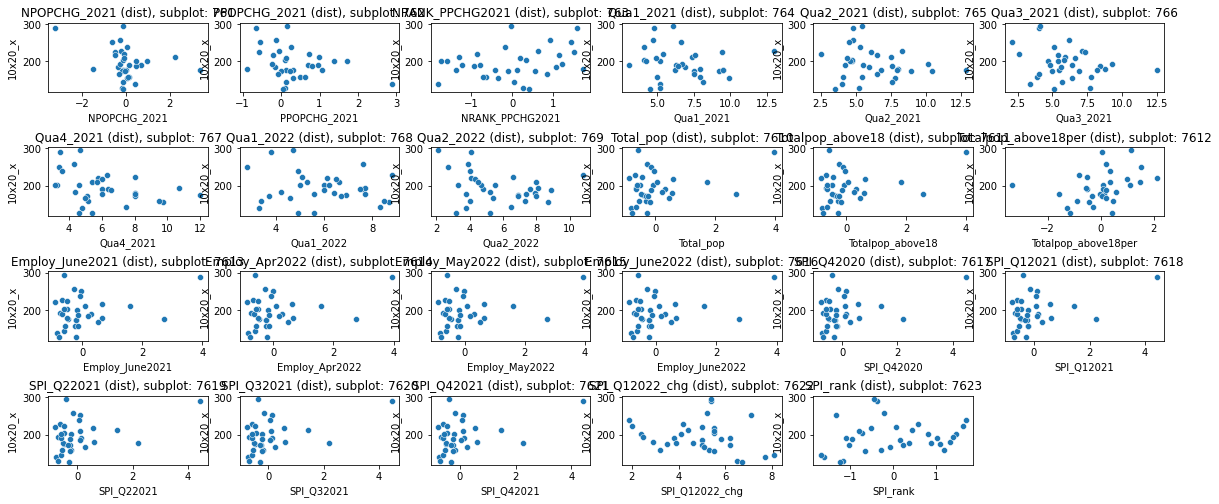

In [666]:
#  plot Numerical Data vs one price variable, there may contains some linear trend between input and output var
# but the input data is small, the patterns are not very clear
a = 7  # number of rows
b = 6  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(20,15))

for i in vals:
    plt.subplot(a, b, c)
    plt.subplots_adjust(hspace=0.8)
    plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.scatterplot(data=final, x=final[i], y='10x20_x')
    c = c + 1

plt.show()

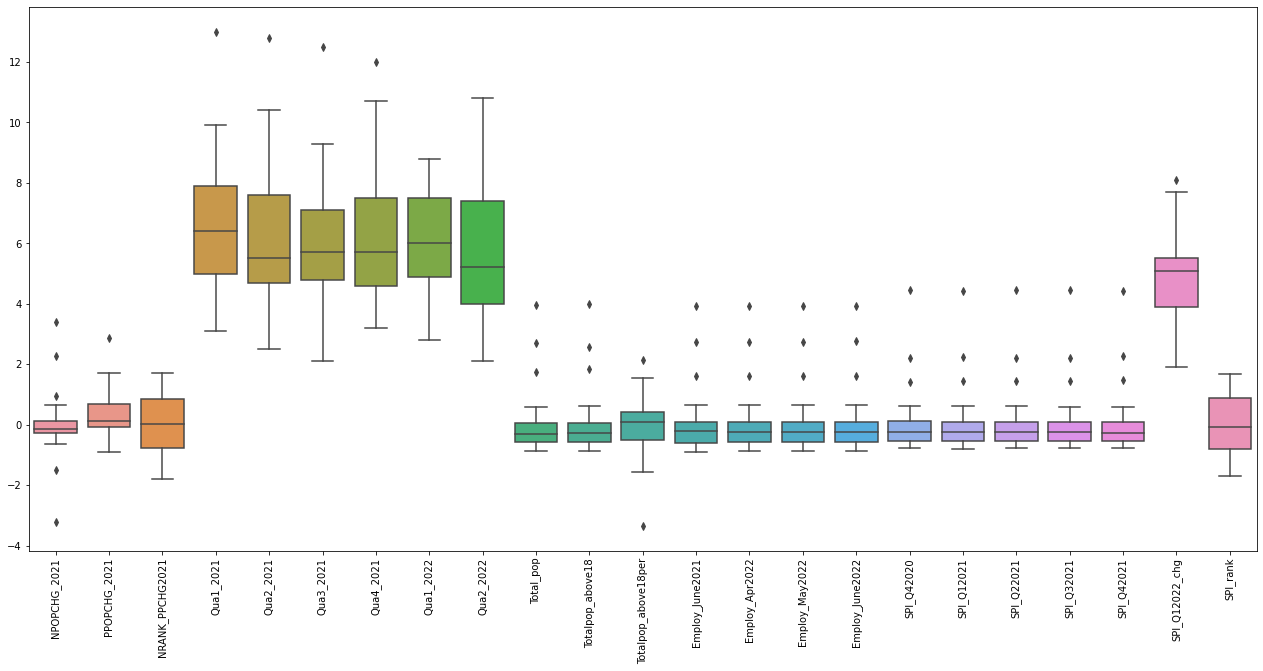

In [667]:
## boxplot check, see if any outstanding outliers
plt.figure(figsize=(22,10))
plt.xticks(rotation =90)
sns.boxplot(data = final[vals])
plt.show()

## seems that the y variable is normally distributied by looking at the histogram 

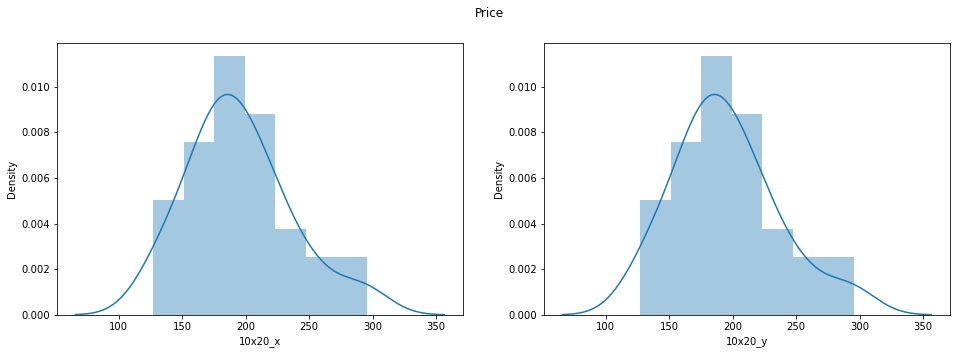

In [608]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
s = sns.distplot((final['10x20_x']), ax = ax1)
s = sns.distplot((final['10x20_y']), ax = ax2)
plt.suptitle("Price")
plt.show();

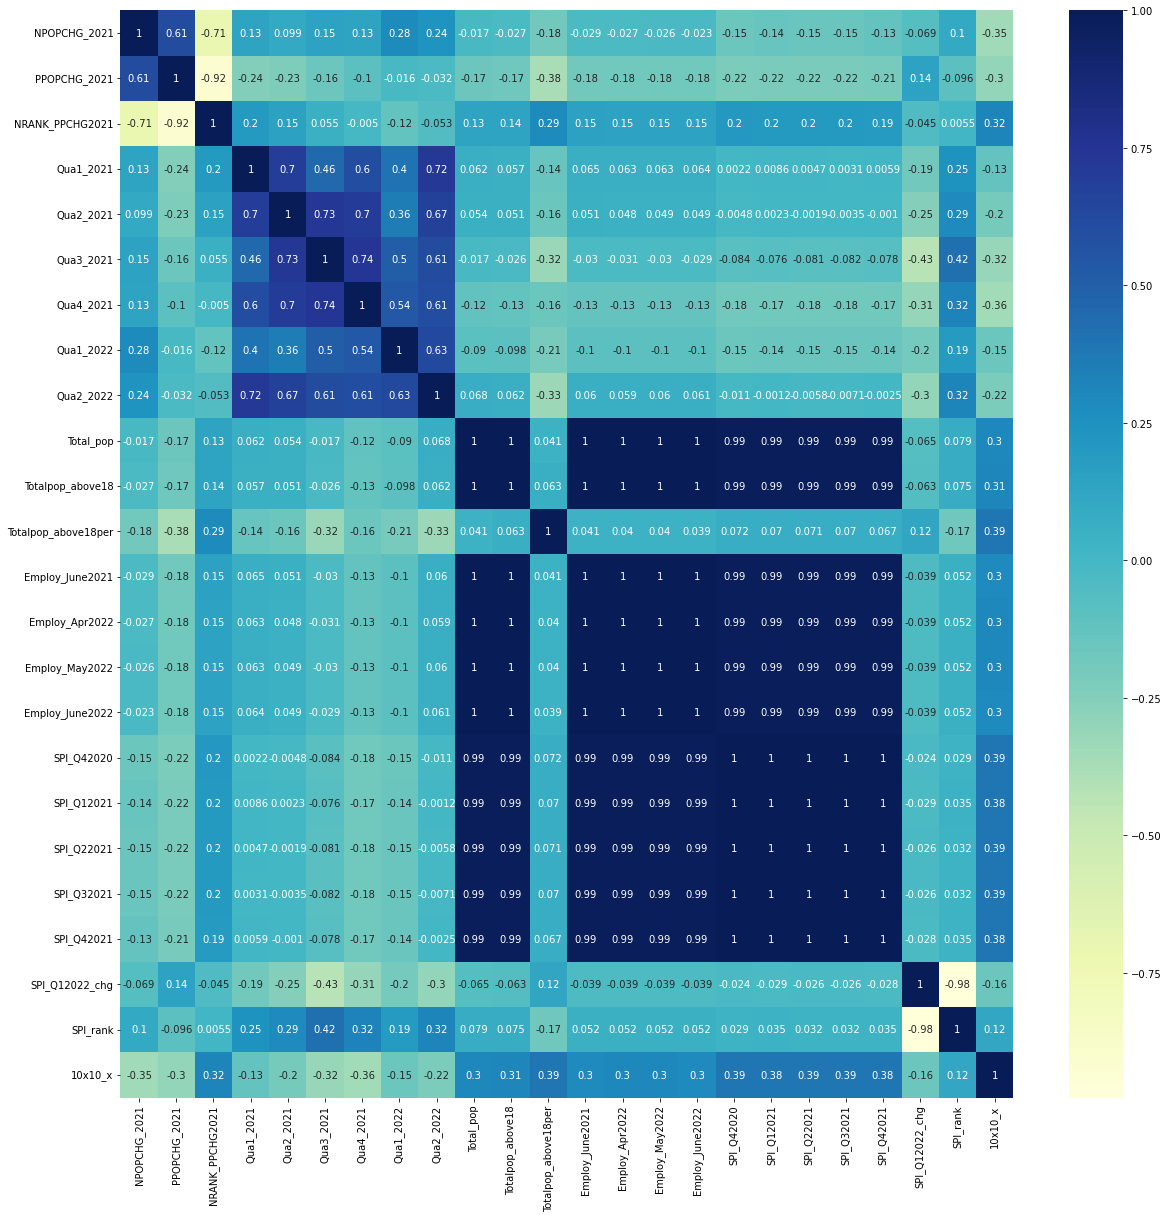

In [609]:
# Looking at the correlation table, if the value is > 0.75, seems the are highly correlated with each other 
vals_add10x20_x= vals + ['10x10_x']
plt.figure(figsize = (20,20))
sns.heatmap(final[vals_add10x20_x].corr(),cmap="YlGnBu", annot=True)
plt.show()

In [668]:
#Train and test datasets for modelling
X=final.iloc[:,1:24]
y=final['10x10_x']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10)
## the following input set are excluding highly correlated variables according to the above correlation plot
X2 = X[["PPOPCHG_2021","NRANK_PPCHG2021","Qua2_2022","Totalpop_above18per", 
                              "Employ_June2022","SPI_Q42021", "SPI_Q12022_chg", "SPI_rank"]]
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y, test_size = 0.2, random_state = 10)

Accuracy of the model : 0.9829822289047702
Model coefficients : [ 7.26000670e+00  5.10532549e+01  2.36621420e+01  2.83349169e+00
  6.73945397e+00 -4.88916745e+00 -9.98132958e-01  3.49501375e+00
 -8.37866366e-01 -3.51670826e+02  1.23918005e+01  1.43348305e+01
 -2.31260458e+03  2.88768032e+03 -2.59533603e+03  2.16144711e+03
  2.13170089e+03  1.42311424e+03 -1.00639363e+03 -3.43201441e+03
  1.06265253e+03 -1.51886199e+01 -1.10969747e+01]
Model intercept value : 120.24994255955787


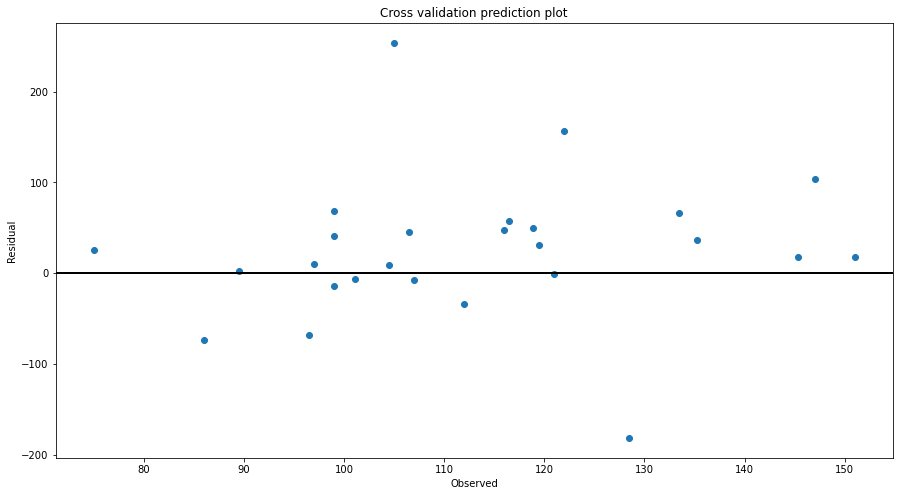

In [670]:
#training model
lr_model=linear_model.LinearRegression() ## simple linear regression 
lr_model
lr_model.fit(X_train,y_train)
#Accuracy of the model
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr) # 0.98 
print('Model coefficients :',lr_model.coef_)
print('Model intercept value :',lr_model.intercept_)
#Cross validation prediction
predict=cross_val_predict(lr_model,X_train,y_train,cv=3) 
## dataset is very small, but let do the standard steps
predict
#Cross validation plot
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()
## residual plot is randomly distributied arround 0 
## some residuals are very large

In [636]:
## brief look at the model results
x2 = sm.add_constant(X_train)
models = sm.OLS(y_train,x2)
result = models.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                10x10_x   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     5.023
Date:                Sat, 13 Aug 2022   Prob (F-statistic):              0.179
Time:                        16:00:34   Log-Likelihood:                -60.288
No. Observations:                  26   AIC:                             168.6
Df Residuals:                       2   BIC:                             198.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 120.2499    

## after remove some correlated variables, in the linear regression result the following variables are statistical significant: 
<br> 1. PPOPCHG_2021 -- population percentage change in 2021; 
<br> 2. NRANK_PPCHG2021 -- rank of population percentage change in 2021; 
<br> 3.Qua2_2022 -- second quater in 2022 rent vacancy rate; 
<br> 4, Totalpop_above18per -- total population of age > 18; 
<br> 5, Employ_June2022 -- employ rate in June 2022; 
<br> 6, SPI_Q42021 -- fourth quater SPI in 2021

In [671]:
# after removing the high correlated variables, we see some significant features for the price 
x2 = sm.add_constant(X_train2)
models = sm.OLS(y_train2,x2)
result = models.fit()
print(result.summary()) 
## PPOPCHG_2021, NRANK_PPCHG2021, Qua2_2022, Totalpop_above18per, Employ_June2022, SPI_Q42021 are statistical significantly 

                            OLS Regression Results                            
Dep. Variable:                10x10_x   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     6.301
Date:                Sun, 14 Aug 2022   Prob (F-statistic):           0.000731
Time:                        12:23:10   Log-Likelihood:                -95.335
No. Observations:                  26   AIC:                             208.7
Df Residuals:                      17   BIC:                             220.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  47.9948    

## Tree visualization, just brief take a look at the candidates and the threshold 

In [672]:
#training the model, this is a very small data so just use very simple tree
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)

In [675]:
#dtr.fit(X_train,y_train)
# export the learned model to tree
#plt.figure(figsize=(20,12))
#tree.plot_tree(dtr.fit(X_train,y_train)) 
#print(X_train2.columns)

Index(['PPOPCHG_2021', 'NRANK_PPCHG2021', 'Qua2_2022', 'Totalpop_above18per',
       'Employ_June2022', 'SPI_Q42021', 'SPI_Q12022_chg', 'SPI_rank'],
      dtype='object')


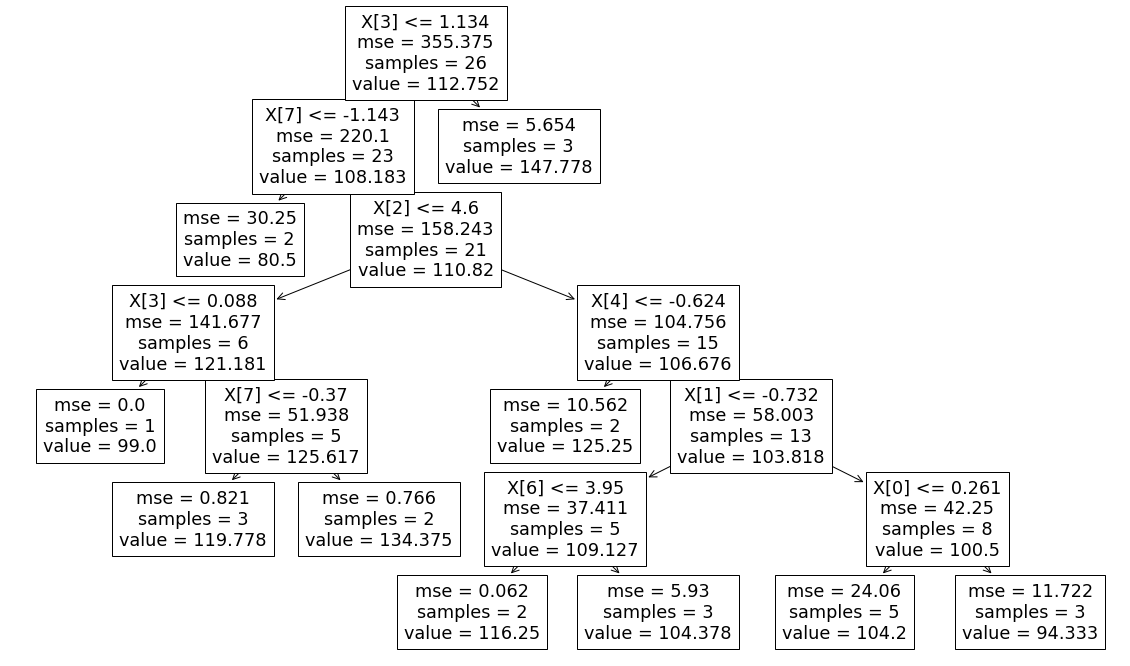

In [674]:
dtr.fit(X_train2,y_train2)
# export the learned model to tree
plt.figure(figsize=(20,12))
tree.plot_tree(dtr.fit(X_train2,y_train2)) 
print(X_train2.columns)

## XGboost and RandomForest are very powerful even working on large dataset, I use them here to just check the feature importance, the linear model already provided good result based on this small dataset

[0]	validation_0-rmse:111.70676
[1]	validation_0-rmse:106.66738
[2]	validation_0-rmse:101.88632
[3]	validation_0-rmse:97.44196
[4]	validation_0-rmse:93.20795
[5]	validation_0-rmse:88.99495
[6]	validation_0-rmse:85.35196
[7]	validation_0-rmse:81.74296
[8]	validation_0-rmse:78.25401
[9]	validation_0-rmse:74.80921
[10]	validation_0-rmse:71.77679
[11]	validation_0-rmse:68.90711
[12]	validation_0-rmse:66.25496
[13]	validation_0-rmse:63.67287
[14]	validation_0-rmse:61.63516
[15]	validation_0-rmse:59.21086
[16]	validation_0-rmse:57.05057
[17]	validation_0-rmse:54.91065
[18]	validation_0-rmse:53.20822
[19]	validation_0-rmse:51.34414
[20]	validation_0-rmse:49.79298
[21]	validation_0-rmse:48.69432
[22]	validation_0-rmse:47.24818
[23]	validation_0-rmse:45.54763
[24]	validation_0-rmse:44.08705
[25]	validation_0-rmse:42.92196
[26]	validation_0-rmse:41.65411
[27]	validation_0-rmse:40.55175
[28]	validation_0-rmse:39.33007
[29]	validation_0-rmse:38.24529
[30]	validation_0-rmse:37.47102
[31]	validation

[252]	validation_0-rmse:21.75395
[253]	validation_0-rmse:21.75487
[254]	validation_0-rmse:21.75521
[255]	validation_0-rmse:21.75687
[256]	validation_0-rmse:21.75780
[257]	validation_0-rmse:21.75770
[258]	validation_0-rmse:21.76092
[259]	validation_0-rmse:21.76162
[260]	validation_0-rmse:21.76251
[261]	validation_0-rmse:21.76400
[262]	validation_0-rmse:21.76353
[263]	validation_0-rmse:21.76308
[264]	validation_0-rmse:21.76250
[265]	validation_0-rmse:21.76156
[266]	validation_0-rmse:21.76514
[267]	validation_0-rmse:21.76684
[268]	validation_0-rmse:21.76688
[269]	validation_0-rmse:21.76664
[270]	validation_0-rmse:21.76662
[271]	validation_0-rmse:21.76638
[272]	validation_0-rmse:21.76575
[273]	validation_0-rmse:21.76476
[274]	validation_0-rmse:21.76506
[275]	validation_0-rmse:21.76378
[276]	validation_0-rmse:21.76460
[277]	validation_0-rmse:21.76505
[278]	validation_0-rmse:21.76532
[279]	validation_0-rmse:21.76422
[280]	validation_0-rmse:21.76414
[281]	validation_0-rmse:21.76679
[282]	vali

[501]	validation_0-rmse:21.76545
[502]	validation_0-rmse:21.76541
[503]	validation_0-rmse:21.76542
[504]	validation_0-rmse:21.76539
[505]	validation_0-rmse:21.76539
[506]	validation_0-rmse:21.76539
[507]	validation_0-rmse:21.76538
[508]	validation_0-rmse:21.76540
[509]	validation_0-rmse:21.76542
[510]	validation_0-rmse:21.76539
[511]	validation_0-rmse:21.76535
[512]	validation_0-rmse:21.76533
[513]	validation_0-rmse:21.76529
[514]	validation_0-rmse:21.76529
[515]	validation_0-rmse:21.76527
[516]	validation_0-rmse:21.76524
[517]	validation_0-rmse:21.76522
[518]	validation_0-rmse:21.76526
[519]	validation_0-rmse:21.76522
[520]	validation_0-rmse:21.76518
[521]	validation_0-rmse:21.76518
[522]	validation_0-rmse:21.76518
[523]	validation_0-rmse:21.76518
[524]	validation_0-rmse:21.76518
[525]	validation_0-rmse:21.76515
[526]	validation_0-rmse:21.76515
[527]	validation_0-rmse:21.76515
[528]	validation_0-rmse:21.76512
[529]	validation_0-rmse:21.76512
[530]	validation_0-rmse:21.76510
[531]	vali

[750]	validation_0-rmse:21.76482
[751]	validation_0-rmse:21.76482
[752]	validation_0-rmse:21.76482
[753]	validation_0-rmse:21.76482
[754]	validation_0-rmse:21.76482
[755]	validation_0-rmse:21.76482
[756]	validation_0-rmse:21.76483
[757]	validation_0-rmse:21.76484
[758]	validation_0-rmse:21.76484
[759]	validation_0-rmse:21.76484
[760]	validation_0-rmse:21.76484
[761]	validation_0-rmse:21.76483
[762]	validation_0-rmse:21.76483
[763]	validation_0-rmse:21.76483
[764]	validation_0-rmse:21.76483
[765]	validation_0-rmse:21.76483
[766]	validation_0-rmse:21.76483
[767]	validation_0-rmse:21.76484
[768]	validation_0-rmse:21.76484
[769]	validation_0-rmse:21.76484
[770]	validation_0-rmse:21.76484
[771]	validation_0-rmse:21.76484
[772]	validation_0-rmse:21.76484
[773]	validation_0-rmse:21.76485
[774]	validation_0-rmse:21.76484
[775]	validation_0-rmse:21.76485
[776]	validation_0-rmse:21.76485
[777]	validation_0-rmse:21.76485
[778]	validation_0-rmse:21.76485
[779]	validation_0-rmse:21.76485
[780]	vali

[999]	validation_0-rmse:21.76478
1000


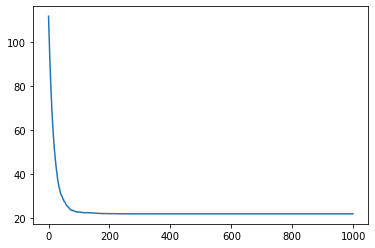

In [646]:
xgbmodel= xgb.XGBRegressor(learning_rate=0.05, 
                           max_depth=5, 
                           min_child_weight=1, 
                           n_estimators=1000, 
                           random_state=1234,
                           alpha=0.01, 
                           subsample=0.8,
                           colsample_bytree=0.6,
                           tree_method='exact', 
                           eval_metric='rmse')
xgbmodelfit=xgbmodel.fit(X_train, y_train, verbose=True, eval_set=[(X_val, y_val)])
evals_result = xgbmodelfit.evals_result()
tempresulst = evals_result['validation_0']['rmse']
print(len(tempresulst))
plt.plot(list(range(0, 1000)), tempresulst)

21.764778999133355


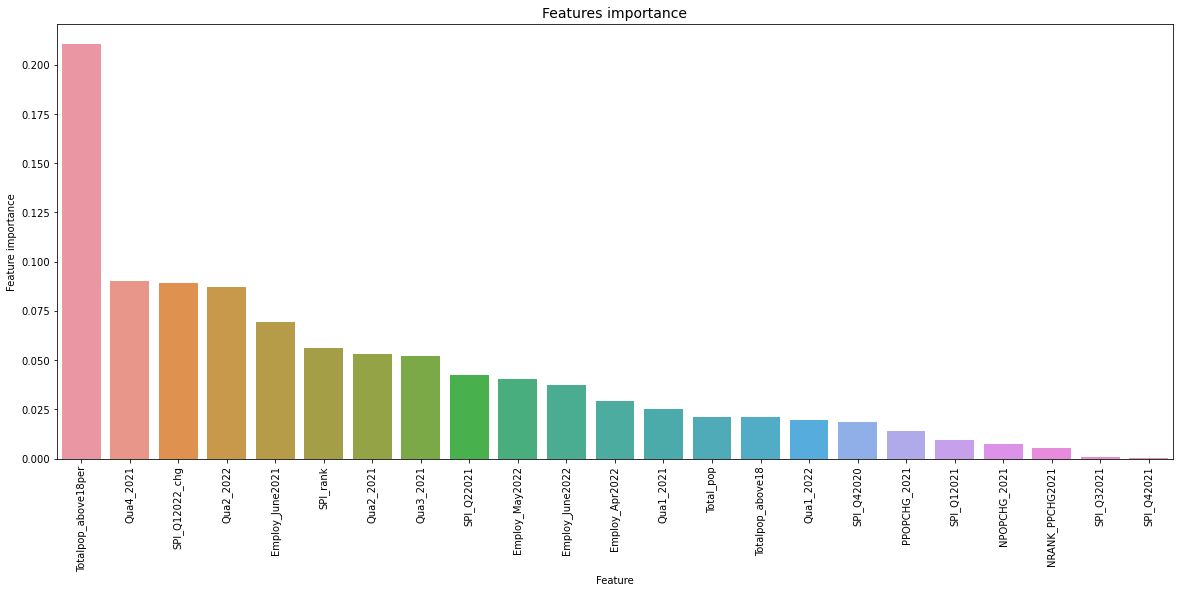

In [676]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))
xgb_valid=xgbmodel.predict(X_val)
print(rmsle(y_val, xgb_valid)) # 21.76
# plot the feature imporatance by the decreasing order
tmp_xgboost = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': xgbmodelfit.feature_importances_})
tmp_xgboost = tmp_xgboost.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (20,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp_xgboost[:30])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

In [677]:
#Training the RF
#rf=RandomForestRegressor(n_estimators=1000)
#Fit the trained model
#rf.fit(X_train,y_train)
#accuracy of the model
#rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)
#predict=cross_val_predict(rf,X_train,y_train,cv=5)
#predict

Accuracy of the model : 0.8513589371165584


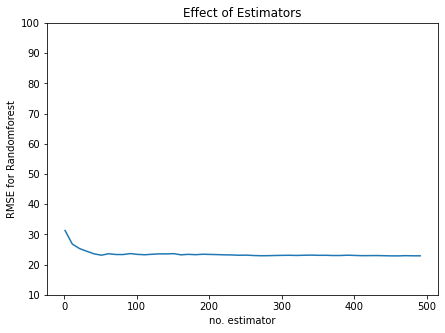

In [678]:
model = RandomForestRegressor(n_jobs=-1,random_state =1234)
# Try different numbers of n_estimators - takes some time
estimators = np.arange(1, 500, 10)
rmse_rf = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    ypred = model.predict(X_val)
    rmse_rf.append(np.sqrt(np.mean(np.square(y_val - ypred))))  
plt.figure(figsize=(7, 5))
plt.title("Effect of Estimators")
plt.xlabel("no. estimator")
plt.ylabel("RMSE for Randomforest")
plt.ylim((10,100))
plt.plot(estimators, rmse_rf)

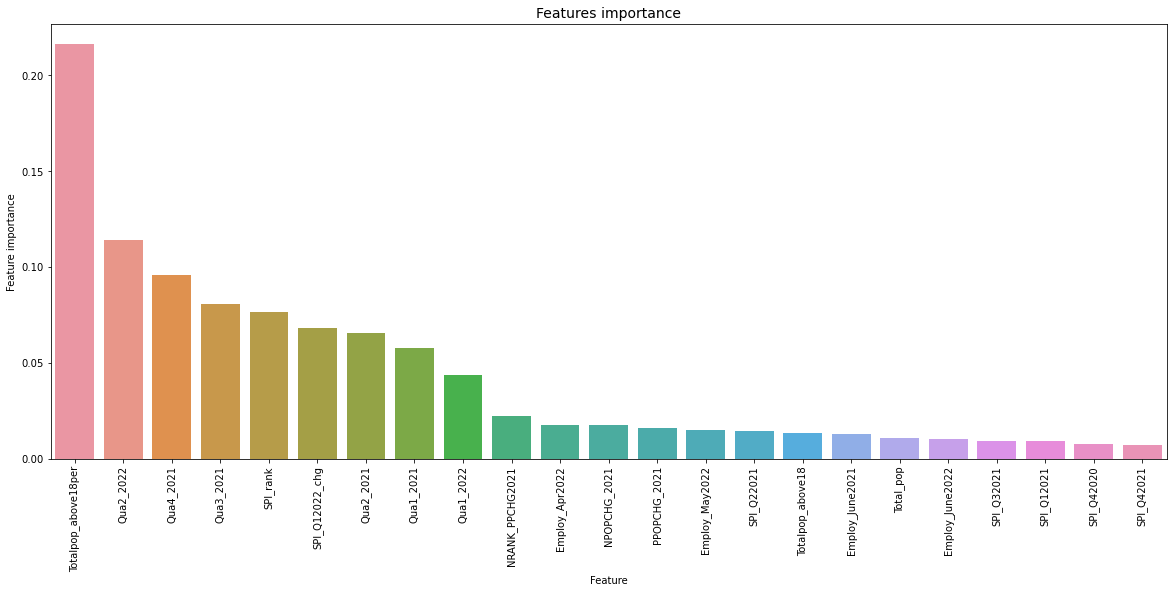

In [683]:
## can use n_estimators = 500, build 500 trees 
rf_model = RandomForestRegressor(n_estimators = 500, n_jobs = -1,random_state =1234)
rfmodel = rf_model.fit(X_train, y_train)
tmp_rf = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': rfmodel.feature_importances_})
tmp_rf = tmp_rf.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (20,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp_rf[:30])
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [684]:
rf_score =rf_model.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.8536692171576356


look at the top features that selected by xgboost and randomforest

In [660]:
tmp_xgboost["Feature"][0:15]

11    Totalpop_above18per
6               Qua4_2021
21         SPI_Q12022_chg
8               Qua2_2022
12        Employ_June2021
22               SPI_rank
4               Qua2_2021
5               Qua3_2021
18             SPI_Q22021
14         Employ_May2022
15        Employ_June2022
13         Employ_Apr2022
3               Qua1_2021
9               Total_pop
10       Totalpop_above18
Name: Feature, dtype: object

In [661]:
tmp_rf["Feature"][0:15]

11    Totalpop_above18per
8               Qua2_2022
6               Qua4_2021
5               Qua3_2021
22               SPI_rank
21         SPI_Q12022_chg
4               Qua2_2021
3               Qua1_2021
7               Qua1_2022
2         NRANK_PPCHG2021
13         Employ_Apr2022
0            NPOPCHG_2021
1            PPOPCHG_2021
14         Employ_May2022
18             SPI_Q22021
Name: Feature, dtype: object

## we see the results from the three models provide similiar predictors for outcome 
<br> 1, in linear regression,the predictors are 'PPOPCHG_2021','NRANK_PPCHG2021','Qua2_2022','Totalpop_above18per', 'Employ_June2022','SPI_Q42021'; 
<br> 2, in the XGboost, the top imporant features are : 
'Totalpop_above18per', 'Qua4_2021', 'SPI_Q12022_chg', 'Qua2_2022', 'Employ_June2021', 'SPI_rank', etc. 
<br> 3, in the randomforest, the top imporant features are : 
'Totalpop_above18per', 'Qua2_2022','Qua4_2021', 'Qua3_2021','SPI_rank','SPI_Q12022_chg', etc. 